# Investigating classification methods for Fashion-MNIST

Team: Fashion Model(er)s
  
Members: Crystal Chiu, Anthony Cusimano, Junwei Hu

## Import Libraries

In [35]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

seed = 1234
np.random.seed(seed)

## Load Data

In [4]:
fashion_data = fetch_openml('Fashion-MNIST', version=1, parser='auto')
X, y = fashion_data.data, fashion_data.target

In [20]:
# Split data into train (0.6), validation (0.2), and test (0.2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = seed)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25, random_state = seed)

In [21]:
X_train.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
43461,0,0,0,0,0,0,1,2,1,0,...,94,113,90,0,0,0,0,0,0,0
61197,0,0,0,0,0,0,1,0,0,18,...,0,0,0,68,87,36,36,7,0,0
8320,0,0,0,0,0,0,0,0,0,0,...,171,188,152,0,0,0,0,0,0,0
27369,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
67090,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
X.shape

(70000, 784)

## Visualization

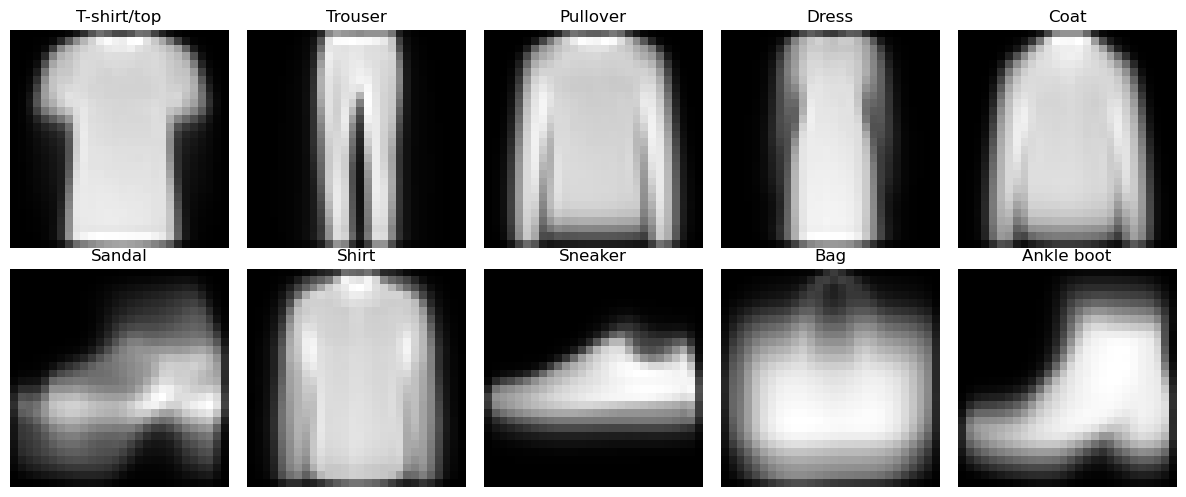

In [8]:
# Visualizing average image for each class
X_plot = X.to_numpy()
y_plot = y.to_numpy()
X_plot = X_plot.reshape(-1, 28, 28).astype(np.uint8)
y_plot = y_plot.astype(int)

num_classes = 10
average_images = np.zeros((num_classes, 28, 28))

for i in range(num_classes):
    class_images = X_plot[y_plot == i]
    average_images[i] = np.mean(class_images, axis=0)

# Plot the average images
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
axes = axes.flatten()

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

for i, ax in enumerate(axes):
    ax.imshow(average_images[i], cmap='gray')
    ax.set_title(class_names[i])
    ax.axis('off')

plt.tight_layout()
plt.show()

## SVC model

#### Grid search

In [44]:
svc = SVC(random_state = seed)

param_grid = {
    'C': [0.1, 1.0, 10, 100], 
    'gamma': ['scale', 'auto'],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}

subset_limit = 2000

grid_search_svc = GridSearchCV(estimator = svc, param_grid = param_grid, scoring = "accuracy", n_jobs = -1)
grid_search_svc.fit(X_train[:subset_limit], y_train[:subset_limit])

y_pred = grid_search_svc.predict(X_test)

# Get train and test accuracy
#train_accuracy = accuracy_score(y_train[:subset_limit], svc.predict(X_train[:subset_limit]))
test_accuracy = accuracy_score(y_test, y_pred)

print("Best parameters found: ", grid_search_svc.best_params_)


# start_time = time.time()
# svc.fit(X_train, y_train)
# end_time = time.time()



# print(f"Training Accuracy: {train_accuracy}")
# print(f"Validation Accuracy: {test_accuracy}")
# print(f"Training Time: {end_time - start_time:.2f} seconds")

# # Detailed classification report
# y_pred = svc.predict(X_test)
# print(classification_report(y_test, y_pred))

# Confusion Matrix
print("Test accuracy: ", test_accuracy)
confusion_matrix(y_test, y_pred)

Best parameters found:  {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Test accuracy:  0.8461428571428572


array([[1204,    5,   20,   57,    7,    1,  116,    0,   18,    0],
       [   5, 1303,    6,   38,    4,    0,    1,    0,    0,    0],
       [  40,    2,  974,   11,  176,    1,  160,    0,   13,    0],
       [  77,    5,   31, 1210,   60,    0,   37,    0,    4,    0],
       [  10,    3,  115,   58, 1099,    1,  111,    0,    5,    0],
       [   3,    0,    1,    1,    0, 1340,    0,   74,    2,   41],
       [ 272,    3,  128,   28,  114,    0,  817,    0,   18,    0],
       [   0,    0,    0,    0,    0,   65,    0, 1226,    2,   79],
       [   9,    1,    9,    3,    9,    3,   16,    4, 1314,    0],
       [   1,    0,    1,    2,    0,   24,    1,   42,    0, 1359]])

#### Accuracy by training size

In [45]:
accuracies_by_size_svc = dict()
time_by_size_svc = dict()

# Using 5%, 15%, 25%, 50%, 75%, and 100% of training set
for prop in [.05, .15, .25]:
    grid_search_svc.fit(X_train[:round(42000*prop)].values.reshape(-1, 28*28), y_train[:round(42000*prop)])

    # Finding prediction time
    start_time = time.time()
    y_pred = grid_search_svc.predict(X_test)
    end_time = time.time()
    time_by_size_svc[round(42000*prop)] = end_time - start_time

    #print(f"Train set size: {round(42000*prop)}")
    #print(f"Accuracy: {accuracy_score(y_test, y_pred)}\n")
    #accuracies_by_size_nn[round(42000*prop)] = accuracy_score(y_test, y_pred)

    # Get train and test accuracy
    #train_accuracy = accuracy_score(y_train[:subset_limit], svc.predict(X_train[:subset_limit]))
    # Add accuracy to dict
    accuracies_by_size_svc[round(42000*prop)] = accuracy_score(y_test, y_pred)

#accuracies_by_size[42000] = accuracy_score(y_test, y_pred2)

/usr/local/Caskroom/miniforge/base/envs/cs178/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/usr/local/Caskroom/miniforge/base/envs/cs178/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/usr/local/Caskroom/miniforge/base/envs/cs178/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


In [51]:
for prop in [.5, .75]:
    grid_search_svc.fit(X_train[:round(42000*prop)].values.reshape(-1, 28*28), y_train[:round(42000*prop)])

    # Finding prediction time
    start_time = time.time()
    y_pred = grid_search_svc.predict(X_test)
    end_time = time.time()
    time_by_size_svc[round(42000*prop)] = end_time - start_time

    accuracies_by_size_svc[round(42000*prop)] = accuracy_score(y_test, y_pred)

KeyboardInterrupt: 

In [ ]:
for prop in [1.0]:
    grid_search_svc.fit(X_train[:round(42000*prop)].values.reshape(-1, 28*28), y_train[:round(42000*prop)])

    # Finding prediction time
    start_time = time.time()
    y_pred_svc = grid_search_svc.predict(X_test)
    end_time = time.time()
    time_by_size_svc[round(42000*prop)] = end_time - start_time

    accuracies_by_size_svc[round(42000*prop)] = accuracy_score(y_test, y_pred_svc)

In [ ]:
conf_matrix_lr = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_lr, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## kNN Classifier

#### Grid Search

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# Create the k-NN classifier
knn = KNeighborsClassifier(n_jobs = -1)

# Define the parameter grid
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'metric': ['euclidean', 'manhattan'],
    'weights': ['uniform', 'distance']
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(knn, param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train.values.reshape(-1, 28*28), y_train)

# Output the best parameters
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_}")

y_pred = grid_search.predict(X_val)

# Confusion Matrix
conf_matrix = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
y_pred2 = grid_search.predict(X_test)
print(classification_report(y_test, y_pred2))

#### Accuracy by training size

In [37]:
knn = KNeighborsClassifier(n_jobs = -1, n_neighbors = 5,
    metric = 'manhattan',
    weights = 'distance')


In [ ]:
accuracies_by_size = dict()

# Using 5%, 15%, 25%, 50%, and 75% of training set
for prop in [.05, .15, .25, .5, .75]:
    grid_search.fit(X_train.iloc[:round(42000*prop)].values.reshape(-1, 28*28), y_train.iloc[:round(42000*prop)])
    y_pred = grid_search.predict(X_test)
    #print(f"Train set size: {round(42000*prop)}")
    #print(f"Accuracy: {accuracy_score(y_test, y_pred)}\n")
    accuracies_by_size[round(42000*prop)] = accuracy_score(y_test, y_pred)

accuracies_by_size[42000] = accuracy_score(y_test, y_pred2)

In [ ]:
# Testing accuracies
accuracies_by_size

In [ ]:
training_sizes = list(accuracies_by_size.keys())
accuracies_knn = list(accuracies_by_size.values())

plt.figure(figsize=(10, 6))
plt.plot(training_sizes, accuracies_knn, marker='o', linestyle='-', color='b', label = "kNN")
#plt.plot(training_sizes, accuracies2, marker='s', linestyle='--', color='r', label='Model 2')

plt.title('Test Accuracy by Training Set Size')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')

#plt.grid(True)
plt.legend()
plt.show()

## Feed Forward Neural Network

#### Grid Search

/Users/junweihu/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Learning rate: 0.0005
Training accuracy: 1.0
Validation accuracy: 0.7802857142857142
Test accuracy: 0.7785714285714286


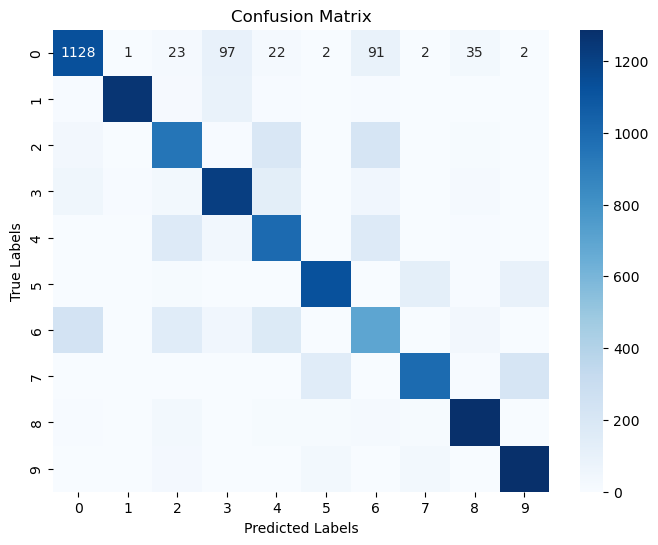

/Users/junweihu/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Learning rate: 0.001
Training accuracy: 1.0
Validation accuracy: 0.776
Test accuracy: 0.7804285714285715


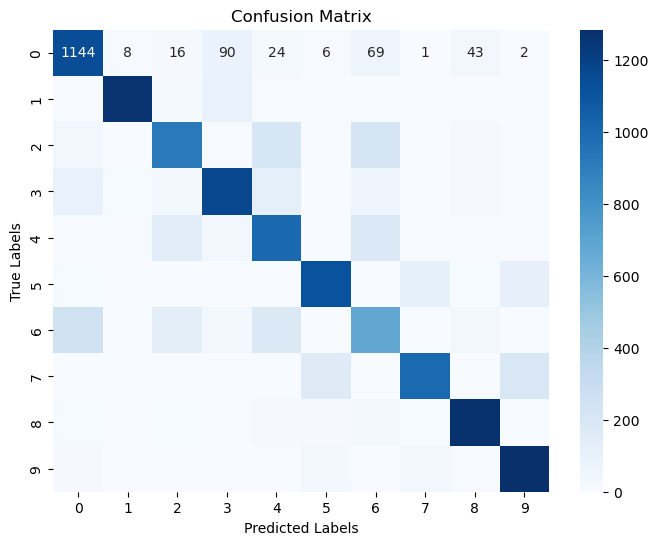

/Users/junweihu/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Learning rate: 0.005
Training accuracy: 1.0
Validation accuracy: 0.7673571428571428
Test accuracy: 0.776


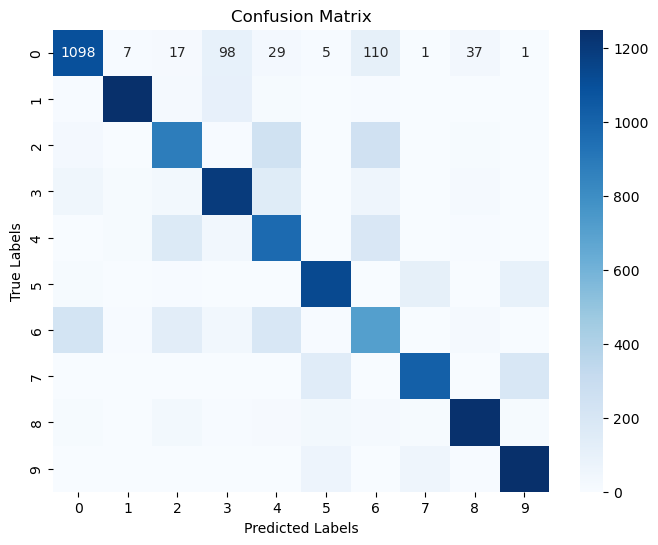

/Users/junweihu/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Learning rate: 0.01
Training accuracy: 1.0
Validation accuracy: 0.7696428571428572
Test accuracy: 0.7716428571428572


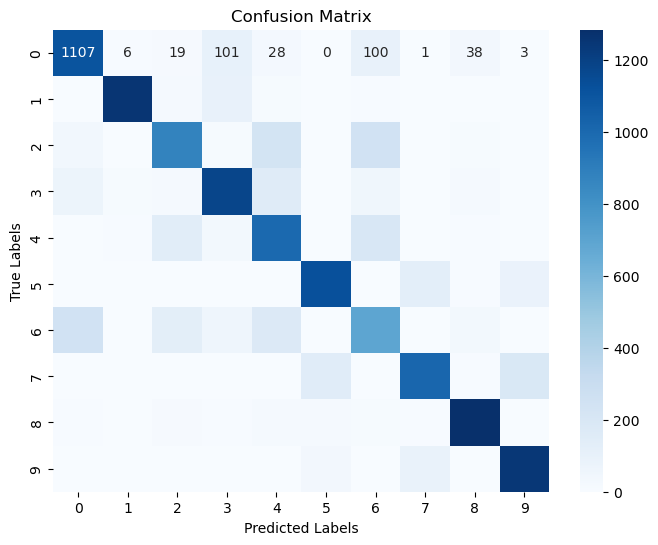

In [14]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

learning_rates = [0.0005, 0.001, 0.005, 0.01]
 
scaler = StandardScaler()
X_train = X_train[:2000]
y_train = y_train[:2000]
# Hu: this subset is what I can run
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
# Hu: used for finetunning
X_test = scaler.transform(X_test)
err_curves = []
for learning_rate_init in learning_rates:
    best_hyperparams = {
       'hidden_layer_sizes': (356, 128, 64),
       'activation': 'relu', 
       'solver': 'adam',
       'alpha': 0.00001,
       'batch_size': 256,
       'learning_rate': 'constant',
       'learning_rate_init': learning_rate_init,
       'max_iter': 100,
       'n_iter_no_change': 100,

    }        
    mlp = MLPClassifier(**best_hyperparams, random_state = seed)
    mlp.fit(X_train, y_train)
    err_curves.append(mlp.loss_curve_)

    train_accuracy = mlp.score(X_train, y_train)
    val_accuracy = mlp.score(X_val, y_val)
    test_accuracy = mlp.score(X_test, y_test)
    print(f'Learning rate: {learning_rate_init}') 
    print(f'Training accuracy: {train_accuracy}')
    print(f'Validation accuracy: {val_accuracy}')
    print(f'Test accuracy: {test_accuracy}')
    
    y_val_pred = mlp.predict(X_val)

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_val, y_val_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    # xticklabels, unnique values in y_test  
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

## Logistic Regression

#### Accuracy by training size

In [ ]:
from sklearn.linear_model import LogisticRegression

accuracies_by_size_lr = dict()
time_by_size_lr = dict()

lr = LogisticRegression(C = 0.01, max_iter = 10000, solver = 'saga', random_state = seed)

# Using 5%, 15%, 25%, 50%, 75% of training set
for prop in [.05, .15, .25, .5, .75]:
    lr.fit(X_train[:round(42000*prop)].values.reshape(-1, 28*28), y_train[:round(42000*prop)])

    # Finding prediction time
    start_time = time.time()
    y_pred = lr.predict(X_test)
    end_time = time.time()
    time_by_size_lr[round(42000*prop)] = end_time - start_time

    # Add accuracy to dict
    accuracies_by_size_lr[round(42000*prop)] = accuracy_score(y_test, y_pred)

print(accuracies_by_size_lr)
print(time_by_size_lr)

In [ ]:
for prop in [.5, .75]:
    lr.fit(X_train[:round(42000*prop)].values.reshape(-1, 28*28), y_train[:round(42000*prop)])

    # Finding prediction time
    start_time = time.time()
    y_pred = lr.predict(X_test)
    end_time = time.time()
    time_by_size_lr[round(42000*prop)] = end_time - start_time

    # Add accuracy to dict
    accuracies_by_size_lr[round(42000*prop)] = accuracy_score(y_test, y_pred)

In [ ]:
for prop in [1.0]:
    lr.fit(X_train[:round(42000*prop)].values.reshape(-1, 28*28), y_train[:round(42000*prop)])

    # Finding prediction time
    start_time = time.time()
    y_pred_lr = lr.predict(X_test)
    end_time = time.time()
    time_by_size_lr[round(42000*prop)] = end_time - start_time

    # Add accuracy to dict
    accuracies_by_size_lr[round(42000*prop)] = accuracy_score(y_test, y_pred_lr)

### Learning Curves

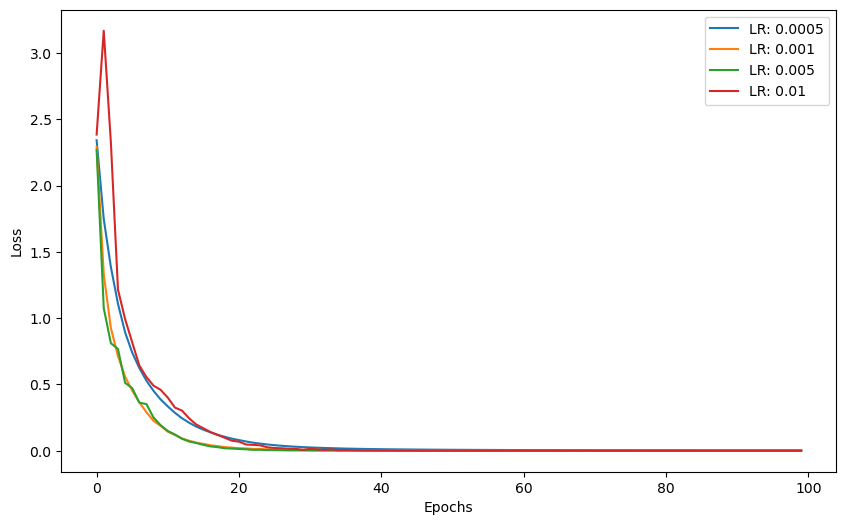

In [13]:
# learning_rates = [0.0005, 0.001, 0.005, 0.01]
# err_curves

plt.figure(figsize=(10, 6))
for i, curve in enumerate(err_curves):
    plt.plot(curve, label=f'LR: {learning_rates[i]}')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend();
plt.show();

In [24]:
scaler = StandardScaler()
subset_int = 2000
X_train_nn = scaler.fit_transform(X_train)
X_train_nn = X_train_nn[:subset_int]
y_train_nn = y_train[:subset_int]
X_val_nn = scaler.transform(X_val)
X_test_nn = scaler.transform(X_test)

best_hyperparams = {
    'hidden_layer_sizes': (356, 128, 64),
    'activation': 'relu', 
    'solver': 'adam',
    'alpha': 0.00001,
    'batch_size': 256,
    'learning_rate': 'constant',
    'learning_rate_init': 0.0005,
    'max_iter': 100,
    'n_iter_no_change': 10,

}        
mlp = MLPClassifier(**best_hyperparams, random_state = seed)
mlp.fit(X_train_nn, y_train_nn)

#y_pred = mlp.predict(X_test_nn)
#accuracy_score(y_test, y_pred)

mlp.score(X_test_nn, y_test)

0.8368571428571429

In [29]:
accuracies_by_size_nn = dict()
X_train_nn = scaler.fit_transform(X_train)

# Using 5%, 15%, 25%, 50%, and 75% of training set
#for prop in [.05, .15, .25, .5, .75]:
for prop in [.05, .15, .25, .5, .75, 1.0]:
    mlp.fit(X_train_nn[:round(42000*prop)].reshape(-1, 28*28), y_train[:round(42000*prop)])
    #y_pred = grid_search.predict(X_test)
    #print(f"Train set size: {round(42000*prop)}")
    #print(f"Accuracy: {accuracy_score(y_test, y_pred)}\n")
    #accuracies_by_size_nn[round(42000*prop)] = accuracy_score(y_test, y_pred)
    accuracies_by_size_nn[round(42000*prop)] = mlp.score(X_test_nn, y_test)

#accuracies_by_size[42000] = accuracy_score(y_test, y_pred2)

In [31]:
for prop in [.5, .75, 1.0]:
    mlp.fit(X_train_nn[:round(42000*prop)].reshape(-1, 28*28), y_train[:round(42000*prop)])
    accuracies_by_size_nn[round(42000*prop)] = mlp.score(X_test_nn, y_test)

In [68]:
accuracies_by_size_knn = dict()
time_by_size_knn = dict()

# Using 5%, 15%, 25%, 50%, and 75% of training set
for prop in [.05, .15, .25, .5, .75, 1.0]:
    knn.fit(X_train.iloc[:round(42000*prop)].values.reshape(-1, 28*28), y_train.iloc[:round(42000*prop)])
    start_time = time.time()
    y_pred = knn.predict(X_test)
    end_time = time.time()
    #print(f"Train set size: {round(42000*prop)}")
    #print(f"Accuracy: {accuracy_score(y_test, y_pred)}\n")
    time_by_size_knn[round(42000*prop)] = end_time - start_time
    accuracies_by_size_knn[round(42000*prop)] = accuracy_score(y_test, y_pred)


/usr/local/Caskroom/miniforge/base/envs/cs178/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
/usr/local/Caskroom/miniforge/base/envs/cs178/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
/usr/local/Caskroom/miniforge/base/envs/cs178/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
/usr/local/Caskroom/miniforge/base/envs/cs178/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
/usr/local/Caskroom/miniforge/base/envs/cs178/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but KNeighborsClassifier was fitted without featur

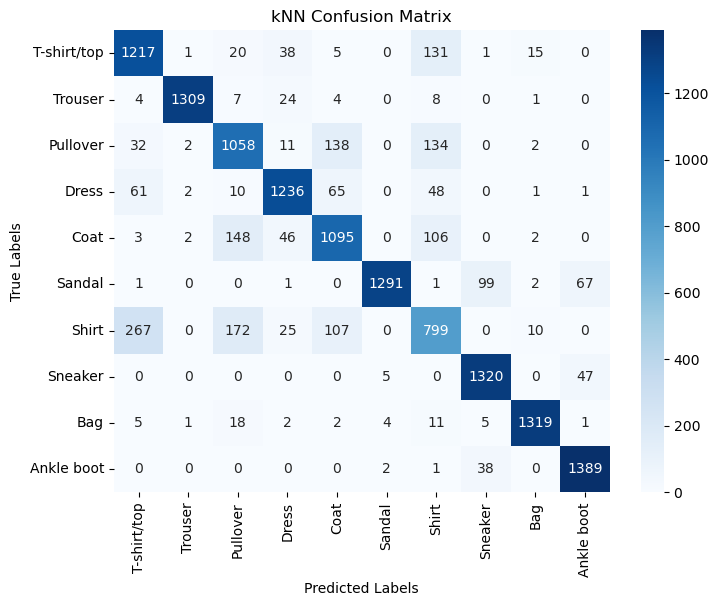

In [79]:
conf_matrix_knn = confusion_matrix(y_test, y_pred)
labelNames = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_knn, annot=True, fmt='d', cmap='Blues', xticklabels=labelNames, yticklabels=labelNames)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('kNN Confusion Matrix')
plt.show()

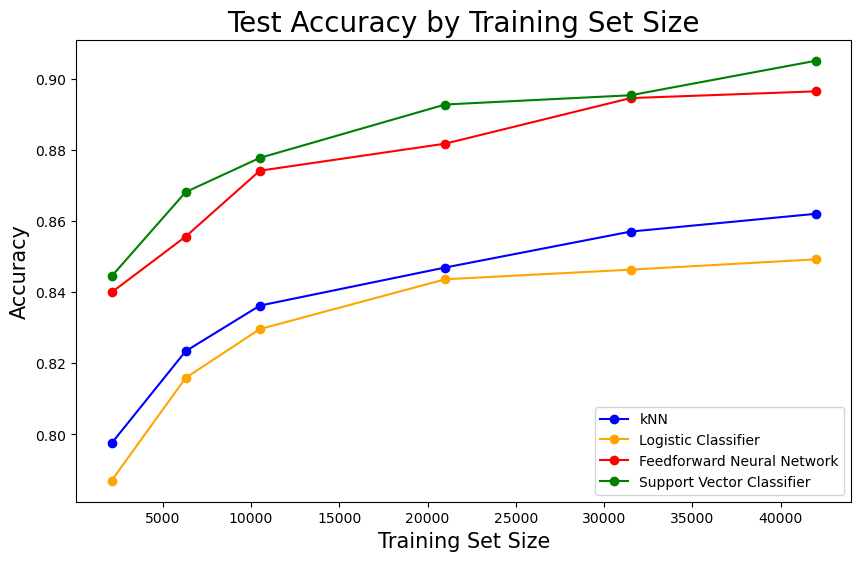

In [86]:
training_sizes = list(accuracies_by_size_nn.keys())

accuracies_nn = [0.8399, 0.8556, 0.8741, 0.8817, 0.8945, 0.8964]
accuracies_knn = [0.7975, 0.8234, 0.8362, 0.8469, 0.857, 0.862]
accuracies_svc = [.8444, .8681, .8777, .8927, .8953, .905]
accuracies_lr = [.787, .8159, .8296, .8436, .8463, .8492]

plt.figure(figsize=(10, 6))
plt.plot(training_sizes, accuracies_knn, marker='o', linestyle='-', color='b', label = "kNN")
plt.plot(training_sizes, accuracies_lr, marker='o', linestyle='-', color='orange', label = "Logistic Classifier")
plt.plot(training_sizes, accuracies_nn, marker='o', linestyle='-', color='r', label = "Feedforward Neural Network")
plt.plot(training_sizes, accuracies_svc, marker='o', linestyle='-', color='g', label = "Support Vector Classifier")

plt.title('Test Accuracy by Training Set Size', size = 20)
plt.xlabel('Training Set Size', size = 15)
plt.ylabel('Accuracy', size = 15)

#plt.grid(True)
plt.legend(loc = "lower right")
plt.show()

In [70]:
time_by_size_knn

{2100: 5.368041038513184,
 6300: 20.986696004867554,
 10500: 36.83997082710266,
 21000: 74.80023407936096,
 31500: 125.3238468170166,
 42000: 151.30775499343872}

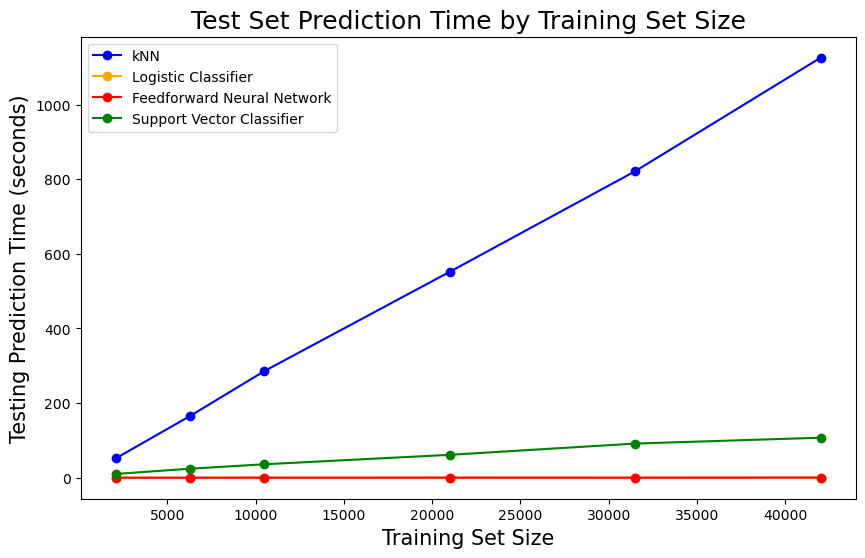

In [87]:
training_sizes = [2100, 6300, 10500, 21000, 31500, 42000]

times_nn = [0.1129, 0.1129, 0.14085, 0.311678, 0.22277, 0.3386]
times_knn = [52.326, 165.686, 285.796, 551.969, 821.5197, 1125.702]
times_svc = [10.15, 24.25, 36.10, 61.42, 91.55, 107.27]
times_lr = [0.02597, 0.02697, 0.02497, 0.02797, 0.02797, 0.3075]

plt.figure(figsize=(10, 6))
plt.plot(training_sizes, times_knn, marker='o', linestyle='-', color='b', label = "kNN")
plt.plot(training_sizes, times_lr, marker='o', linestyle='-', color='orange', label = "Logistic Classifier")
plt.plot(training_sizes, times_nn, marker='o', linestyle='-', color='r', label = "Feedforward Neural Network")
plt.plot(training_sizes, times_svc, marker='o', linestyle='-', color='g', label = "Support Vector Classifier")

plt.title('Test Set Prediction Time by Training Set Size', size = 18)
plt.xlabel('Training Set Size', size = 15)
plt.ylabel('Testing Prediction Time (seconds)', size = 15)

#plt.grid(True)
plt.legend()
plt.show()

In [80]:
len(y_test)

14000